<a href="https://colab.research.google.com/github/myGithubAccount26/Biostatistics/blob/master/Biostatistics_Lab_5_Flowers.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#If training is slow try restarting the notebook and re-run the code

In [ ]:
# Import mcpr package from Dr. Hahn's github
!pip install git+https://github.com/williamedwardhahn/mpcr
from mpcr import *

  Cloning https://github.com/williamedwardhahn/mpcr to /tmp/pip-req-build-w1rds2ub
  Running command git clone -q https://github.com/williamedwardhahn/mpcr /tmp/pip-req-build-w1rds2ub
  Created wheel for ImportMPCR: filename=ImportMPCR-0.0.1-cp36-none-any.whl size=5914 sha256=8e1cc2b0b67fdaf727ba106f7dca7fe4df197665ffc57de05ad0c21d381c6a2a
  Stored in directory: /tmp/pip-ephem-wheel-cache-36274z_0/wheels/89/93/47/ef43fe80a5b823a05d8dcca5ed1581f4fcdacf69b27110603f
Successfully built ImportMPCR


In [ ]:
# Install flashtorch and barbar libraries
!pip install flashtorch
!pip install barbar

  Created wheel for flashtorch: filename=flashtorch-0.1.3-cp36-none-any.whl size=26248 sha256=79140220d7bec9d130d62f90c690295988919d5dbf0b062dcb23c20b9662aeca
  Stored in directory: /root/.cache/pip/wheels/03/6d/b1/2d3c5987b69e900fcceceeef39d3ed92dfe46ba1359b9c79f8
Successfully built flashtorch


In [ ]:
# Import a few functions from flashtorch and itertools
from flashtorch.utils import apply_transforms
from flashtorch.saliency import Backprop
import itertools

In [ ]:
# Mount to current google drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# Create new folder on your google drive like below:

In [ ]:
# Change working directory to drive folder with flower data
os.chdir('/content/drive/My Drive/Data1/flowers102/flower_data')

In [ ]:
#This code will download the dataset
!wget https://gist.githubusercontent.com/JosephKJ/94c7728ed1a8e0cd87fe6a029769cde1/raw/403325f5110cb0f3099734c5edb9f457539c77e9/Oxford-102_Flower_dataset_labels.txt
!wget https://s3.amazonaws.com/content.udacity-data.com/courses/nd188/flower_data.zip
!unzip 'flower_data.zip'

In [ ]:
%ls

flower_data/     Oxford-102_Flower_dataset_labels.txt  valid/
flower_data.zip  train/


In [ ]:
# Read in csv with flower labels
dataset_labels = pd.read_csv('Oxford-102_Flower_dataset_labels.txt',header=None)[0]

In [ ]:
# set directory as a variable
data_dir = '/content/drive/My Drive/Data1/flowers102/flower_data/'

In [ ]:
# Prespecified mean and standard deviations, how were these come up with, what happens if we change our mean array or standard deviation array? 
# For refernce to normalization on pre-trained models: https://pytorch.org/docs/stable/torchvision/models.html and https://github.com/pytorch/vision/pull/1965
mean = np.array([0.485, 0.456, 0.406])
std = np.array([0.229, 0.224, 0.225])

# Here we are setting up our transformations so that for each image we will crop the image, then convert it to a tensor, and then normalize the output for model convergence
data_transforms = {
    'train': transforms.Compose([ # This allows us to stitch transformations together
        transforms.RandomResizedCrop(224),  # This crops the image that we are reading in so that all images are a set size and we do not have to process on the whole image with extra noise
        transforms.RandomHorizontalFlip(), # This flips the image, this seems to be part of the preparation step for the ResNet-18 model
        transforms.ToTensor(), # This converts the image to a tensor array which is easier for processing
        transforms.Normalize(mean, std) # Applies the mean and standard deviation in order to normalize the tensor output
    ]),
    'valid': transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize(mean, std)
    ]),
}

In [ ]:
# This reads in the images within the subdirectories in our flower data folder and then performs our initialized transformations
image_datasets = {x: datasets.ImageFolder(os.path.join(data_dir, x),data_transforms[x]) for x in ['train', 'valid']}

# This takes our images and loads them in random batches of 16
dataloaders = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=16, shuffle=True, num_workers=4) for x in ['train', 'valid']}

# Setting the size of the datasets so we have a measure of the number of images we have loaded in within the train and validation sets
dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'valid']}

# Set the class names for the training set 
class_names = image_datasets['train'].classes

# Sends processing to the device in order to utilize the processing power of the GPU
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [ ]:
dataset_sizes

{'train': 6552, 'valid': 818}

In [ ]:
# Here we are defining our own function for viewing the tensor images we are loading in. Here we can control the size of the image and they will be plotted in a grid
def imshow(inp, title = " "):
    fig, ax = plt.subplots()
    inp = inp.numpy().transpose((1, 2, 0))
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    ax.imshow(inp)
    plt.title(title, loc='center')
    fig.set_size_inches(20, 20)
    plt.show()

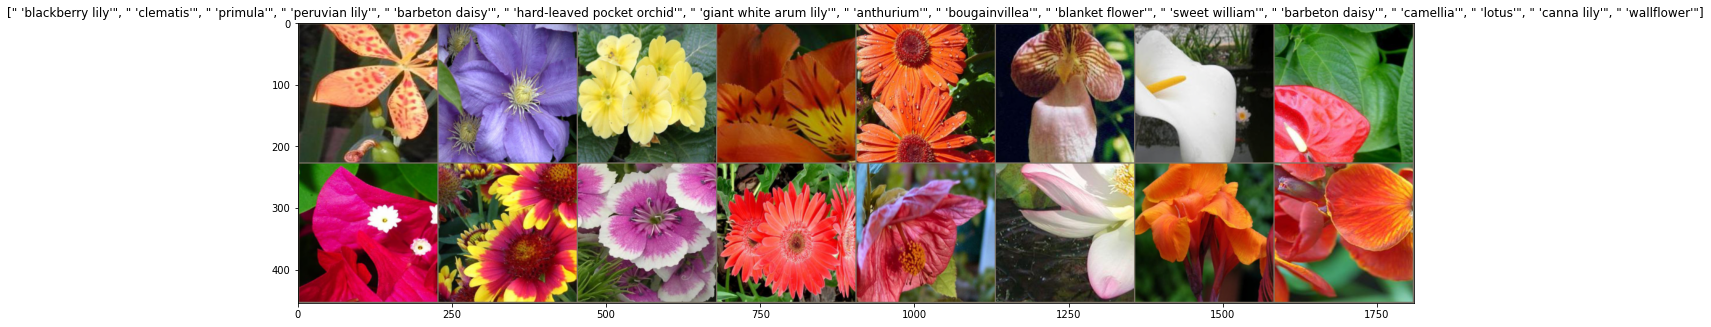

In [ ]:
# Iterate over the images we have loaded
inputs, classes = next(iter(dataloaders['train']))

# Select only the first 16 images and classes
inputs = inputs[:16]
classes = classes[:16] 

# Make a grid in order to view the 16 images we have loaded in
out = torchvision.utils.make_grid(inputs)

# Use the functions defined above in order to plot the flower images
imshow(out, title=[dataset_labels[int(class_names[x])-1] for x in classes])

In [ ]:
from barbar import Bar

In [ ]:
help(nn.CrossEntropyLoss())

In [ ]:
# Here we are defining our training function. This function will loop through the number of epochs and apply set training criteria to our input model
def train_model(model, num_epochs=25):

    # Send model to the device to utilize GPU for faster processing
    model = model.to(device) 

    # This is setting our loss function, we want to use an entropy loss in order to measure the accuracy of our model
    criterion = nn.CrossEntropyLoss() 

    # Establishes the descent method, we use Stochastic Gradient Descent with a loss ratio of 0.001
    optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9) 

    # This is the schedule we will follow for our descent, with each iteration our scheduler will increase in step and we will adjust our optimizer
    scheduler = lr_scheduler.StepLR(optimizer, step_size=7, gamma=0.1) 

    for epoch in range(num_epochs):

        print('Epoch: ',epoch+1,'/',num_epochs)

        ###Train
        model.train() # Set the model into training mode
        running_corrects = 0 # This wil allow us to measure our accuracy
        for inputs, labels in Bar(dataloaders['train']):
            inputs = inputs.to(device)
            labels = labels.to(device)

            optimizer.zero_grad() # Resets the optimizer at the begining of each iteration

            outputs = model(inputs) # Save model outputs

            preds = torch.max(outputs, 1)[1] # Set aside our predictions as the most likely label (the label with the highest predicted score)
            running_corrects += torch.sum(preds == labels.data) # Check to see if our predictions were accurate and add to our tally of correct predictions

            loss = criterion(outputs, labels) # Calculate the loss from the model based on our criterion
            loss.backward() # Backwards step-wise optimization 
            optimizer.step() # increment the optimizer based on the results

        print("Train ", 'Acc: {:.2f}'.format(running_corrects.double()/dataset_sizes['train'])) # Let's view the results in the console
        
        scheduler.step() # Lastly, we need to increment the scheduler so that in the next iteration we will properly desced towards a minimum loss
    
        ###Val
        # Here we are testing our model on the validation set to ensure that we are producing accurate results
        model.eval()  
        running_corrects = 0
        for inputs, labels in Bar(dataloaders['valid']):
            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = model(inputs)
            preds = torch.max(outputs, 1)[1]
            running_corrects += torch.sum(preds == labels.data)

        print("Valid ", 'Acc: {:.2f}'.format(running_corrects.double()/dataset_sizes['valid']))
        print("#######################")
    return model

In [ ]:
# Read in ResNet-18 model, a residual network model with 18 layers
model = models.resnet18(pretrained=True)

# Set aside the features within the model and perform a linear transformation on those features
num_ftrs = model.fc.in_features
model.fc = nn.Linear(num_ftrs, 102)

Downloading: "https://download.pytorch.org/models/resnet18-5c106cde.pth" to /root/.cache/torch/hub/checkpoints/resnet18-5c106cde.pth


In [ ]:
help(model)

In [ ]:
# Use the function we defined above in order to train our model, we can change the number of iterations by controlling the num_epochs parameter
model = train_model(model, num_epochs=3)

Epoch:  1 / 3
6552/6552: [===============================>] - ETA 6.1s
Train  Acc: 0.40
818/818: [===============================>] - ETA 3.2s
Valid  Acc: 0.76
#######################
Epoch:  2 / 3
6552/6552: [===============================>] - ETA 0.6s
Train  Acc: 0.77
818/818: [===============================>] - ETA 0.6s
Valid  Acc: 0.94
#######################
Epoch:  3 / 3
6552/6552: [===============================>] - ETA 0.6s
Train  Acc: 0.86
818/818: [===============================>] - ETA 0.7s
Valid  Acc: 0.95
#######################


In [ ]:
# Redefine the plotting function to use smaller image sizes
def imshow2(inp, title = " "):
    fig, ax = plt.subplots()
    inp = inp.numpy().transpose((1, 2, 0))
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    ax.imshow(inp)
    plt.title(title, loc='center')
    fig.set_size_inches(3, 3)
    plt.show()

# Here we are defining our visualization function, this will plot our image, print the prediction, and print the correct label
def visualize_model(model, num_images=16):
    model.eval()
    index = 0
    for i, (inputs, labels) in enumerate(dataloaders['valid']):
        inputs = inputs.to(device)
        labels = labels.to(device)

        outputs = model(inputs)

        preds = torch.max(outputs, 1)[1]

        for j in range(inputs.size()[0]):
            index += 1
            title1 = 'predicted: ' + dataset_labels[int(class_names[preds[j]])-1] + '     class: ' + dataset_labels[int(class_names[labels[j]])-1]
            imshow2(inputs.cpu().data[j],title1)

            if index == num_images:
                return

In [ ]:
# Visualize the images with their predictions
visualize_model(model)

In [ ]:
# Testing identifying mis-classified images
for i in dataset_labels.index:
  if dataset_labels[i] == " 'columbine'":
    print(i)

83


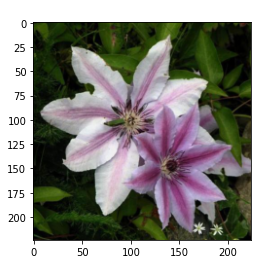

IndexError: ignored

In [ ]:
# This does not seem to be the correct method of visualizign all of the images that were mis-classified, this will need to be revisited if we want to be able to speak to our mis-clasifications
for i, (inputs2, labels) in enumerate(dataloaders['train']):
  if dataset_labels[int(labels[i])] == " 'columbine'":
    imshow(inputs2.cpu().data[i])

In [ ]:
help(dataset_labels)

predicted:  'pink primrose'


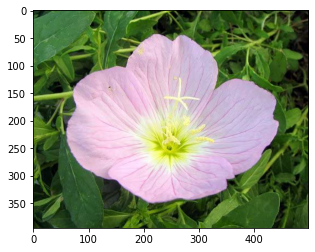

In [ ]:
# Here we are loading in an image from the URL specified
imagePath = 'https://images-na.ssl-images-amazon.com/images/I/51dZp-%2B4W9L._AC_.jpg'

# Read the image
image = io.imread(imagePath)

# Show the image
plt.imshow(image);

# Apply our transformations to the image in order for the model to properly classify it
img = apply_transforms(image).clone().detach().requires_grad_(True).to(device)

# Return our model predictions
outputs = model(img)

# Select the most likely output prediction
preds = torch.max(outputs, 1)[1]

# Print the label that is associated with the most likely prediction value from our model
print('predicted: ' + dataset_labels[int(class_names[preds])-1])

In [ ]:
print('predicted: ' + dataset_labels[int(class_names[preds])-1])

predicted:  'pink primrose'
